In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from __future__ import print_function
from collections import OrderedDict

import os
import sys
import timeit
import pickle

import scipy.io as sio
import numpy as np
import theano
import theano.tensor as T

sys.path.insert(0, "/home/cwhuang/DVTL/Model/")
import nnet as nn
import criteria	as er
import util
import VLDF_ANN

import OfficeFeaturePlot as fp

Using gpu device 0: GeForce GTX TITAN (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5005)


number of minibatch at one epoch: 5, batch size source : 114, target : 97 
 validation size, S:330, T:280, test size, S:220, T:190
... building the model
Encoder1_share is constructed with hidden layer number 1
Encoder1_mu is constructed with hidden layer number 0
Encoder1_sigma is constructed with hidden layer number 0
Encoder5_pi is constructed with hidden layer number 1
Encoder3_share is constructed with hidden layer number 0
Encoder3_mu is constructed with hidden layer number 0
Encoder3_sigma is constructed with hidden layer number 0
Encoder2_share is constructed with hidden layer number 1
Encoder2_mu is constructed with hidden layer number 0
Encoder2_sigma is constructed with hidden layer number 0
Encoder4_share is constructed with hidden layer number 0
Encoder4_mu is constructed with hidden layer number 0
Encoder4_sigma is constructed with hidden layer number 0
Decoder1_share is constructed with hidden layer number 0
Decoder1_mu is constructed with hidden layer number 0
Decoder1_

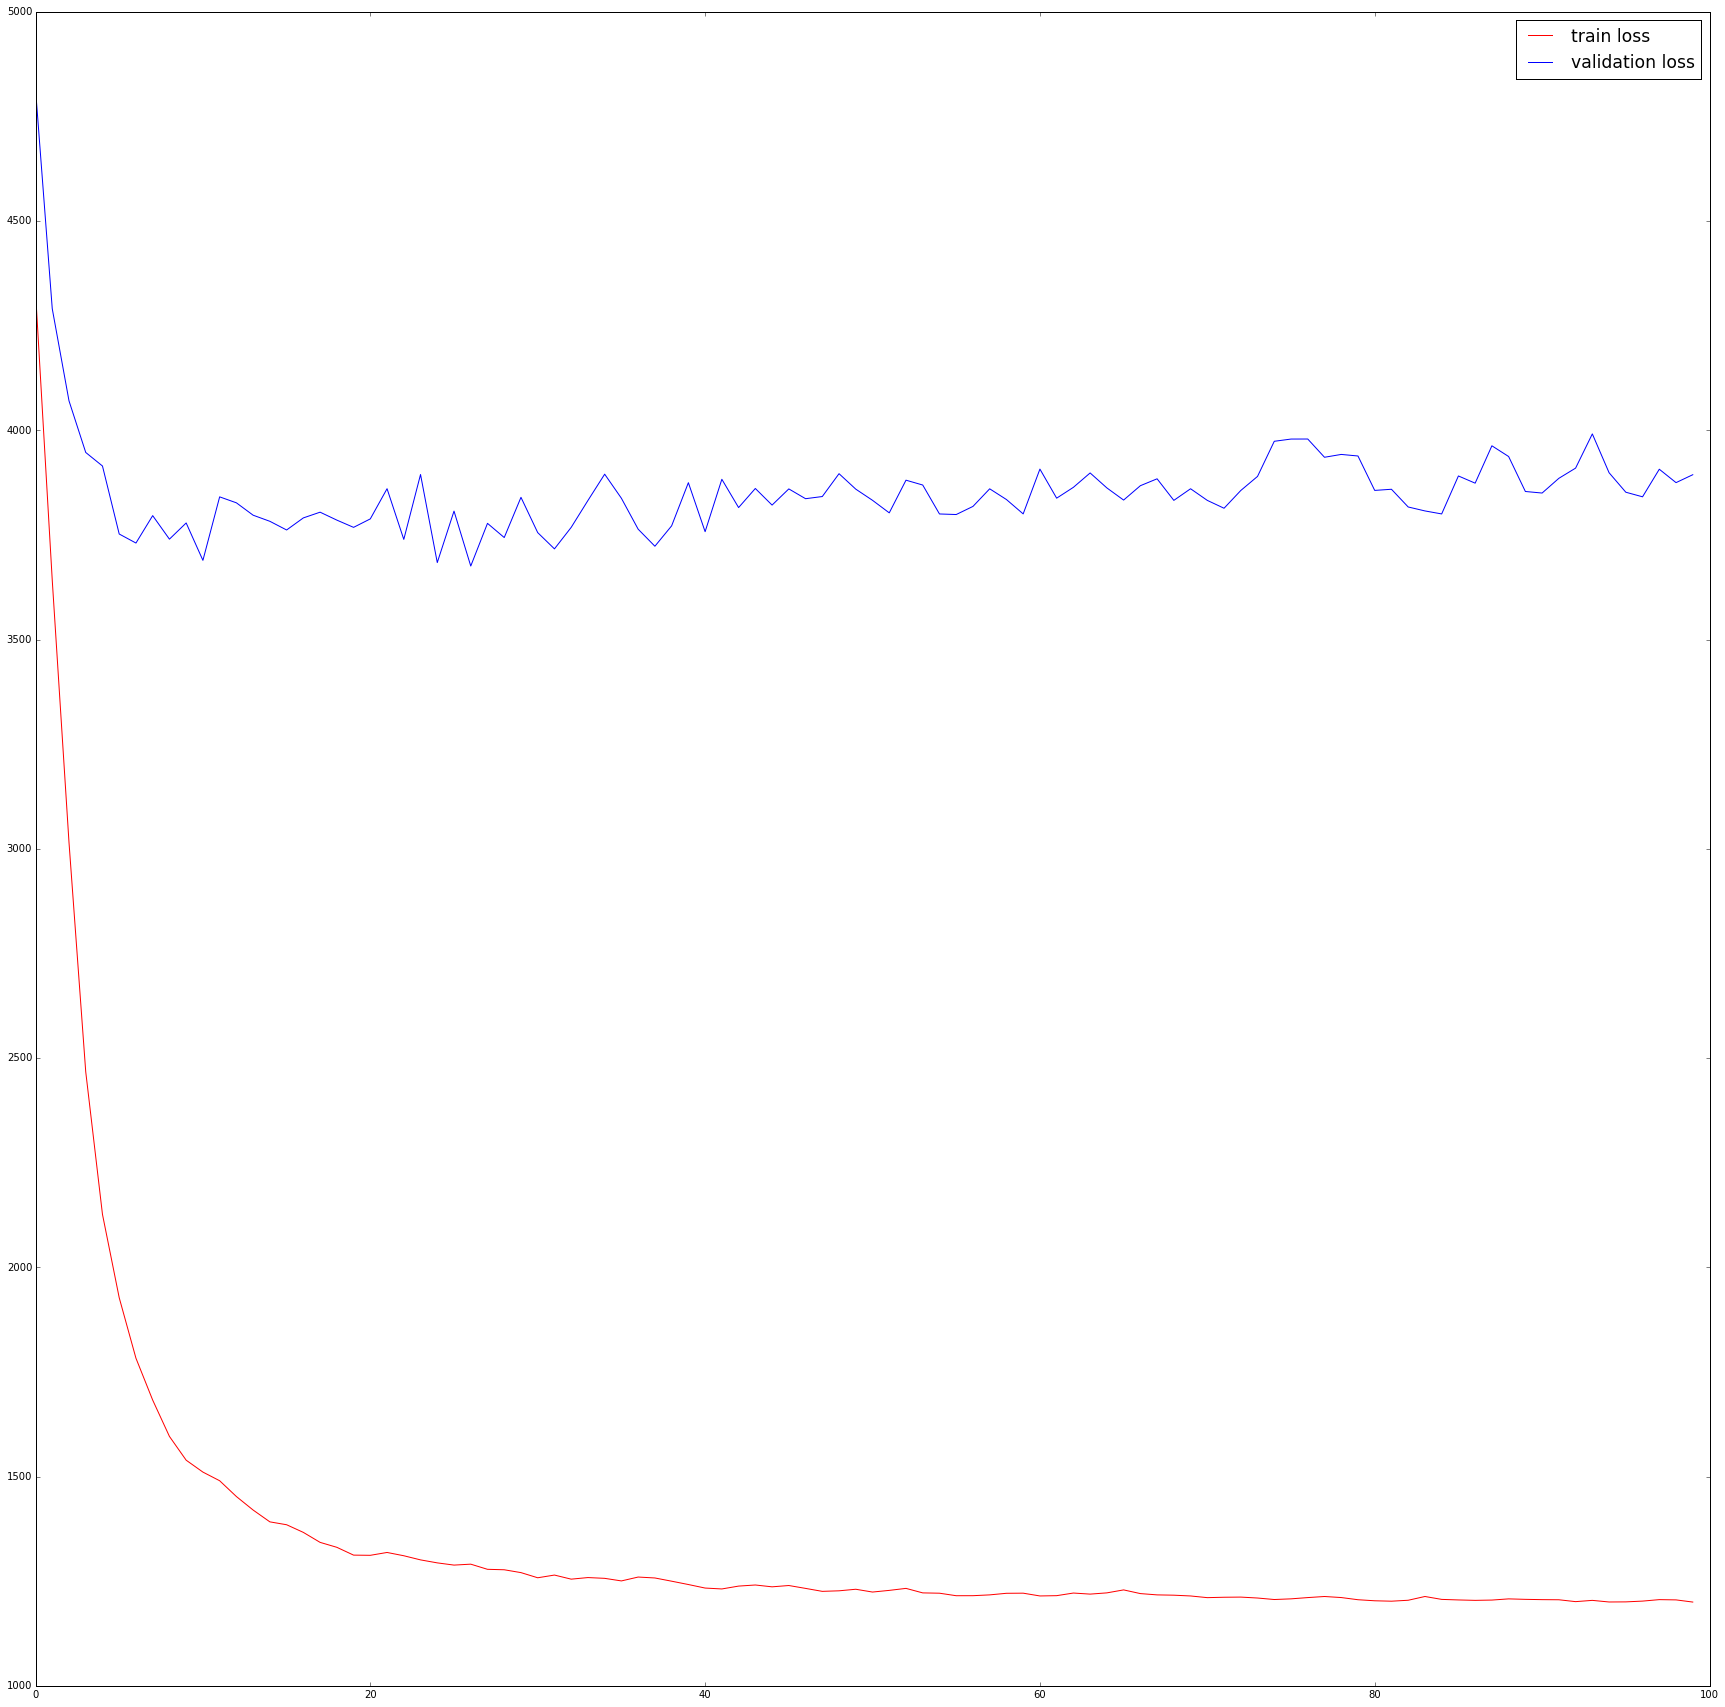

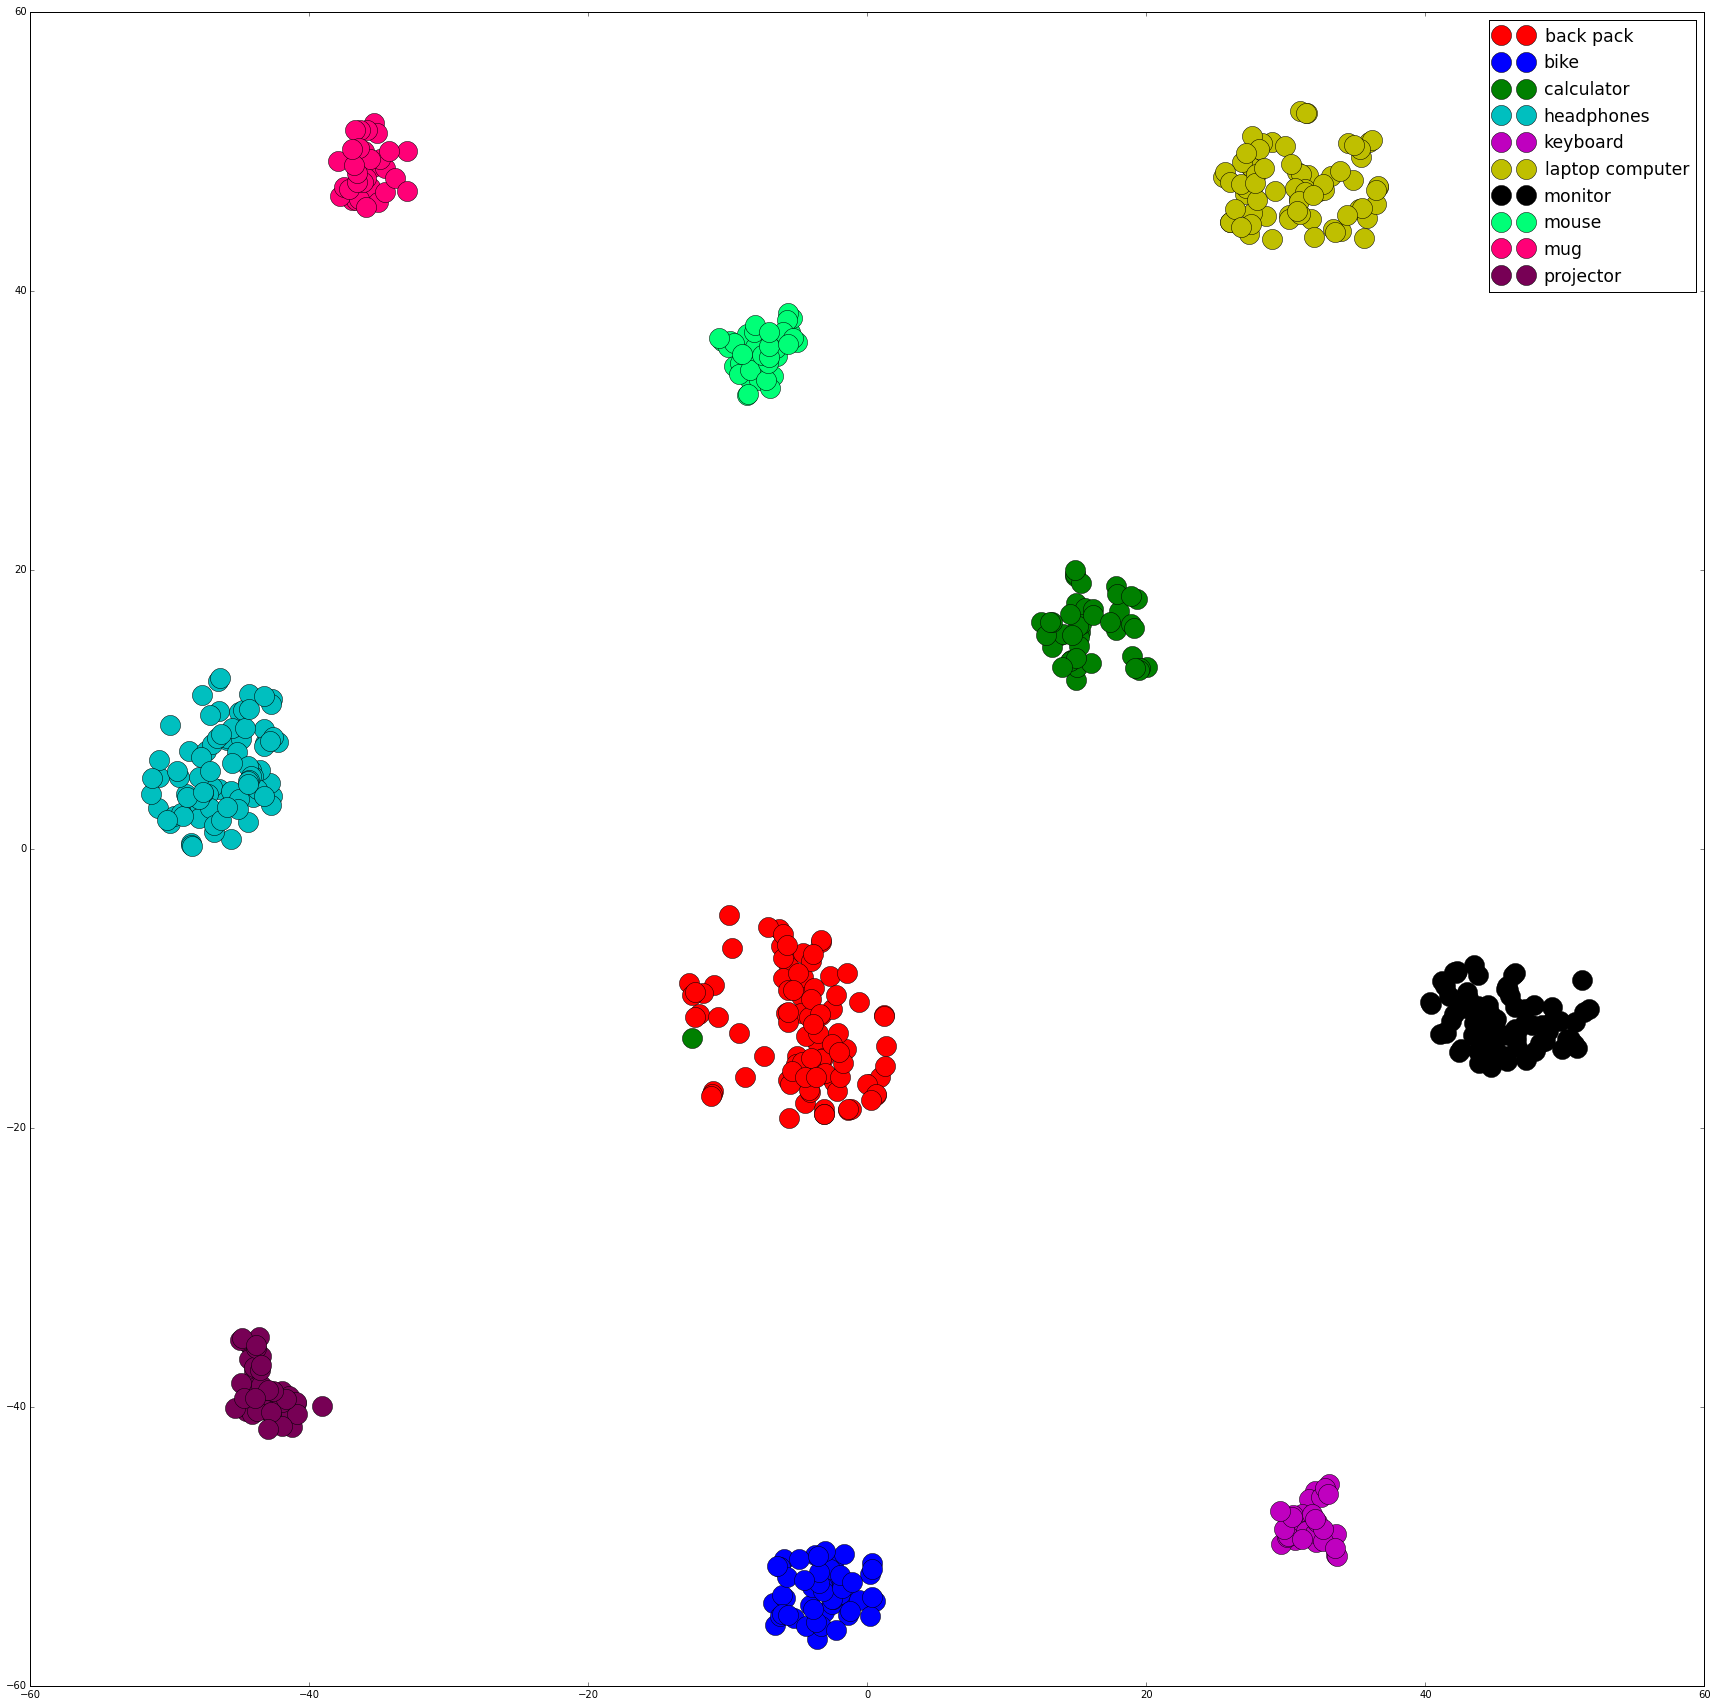

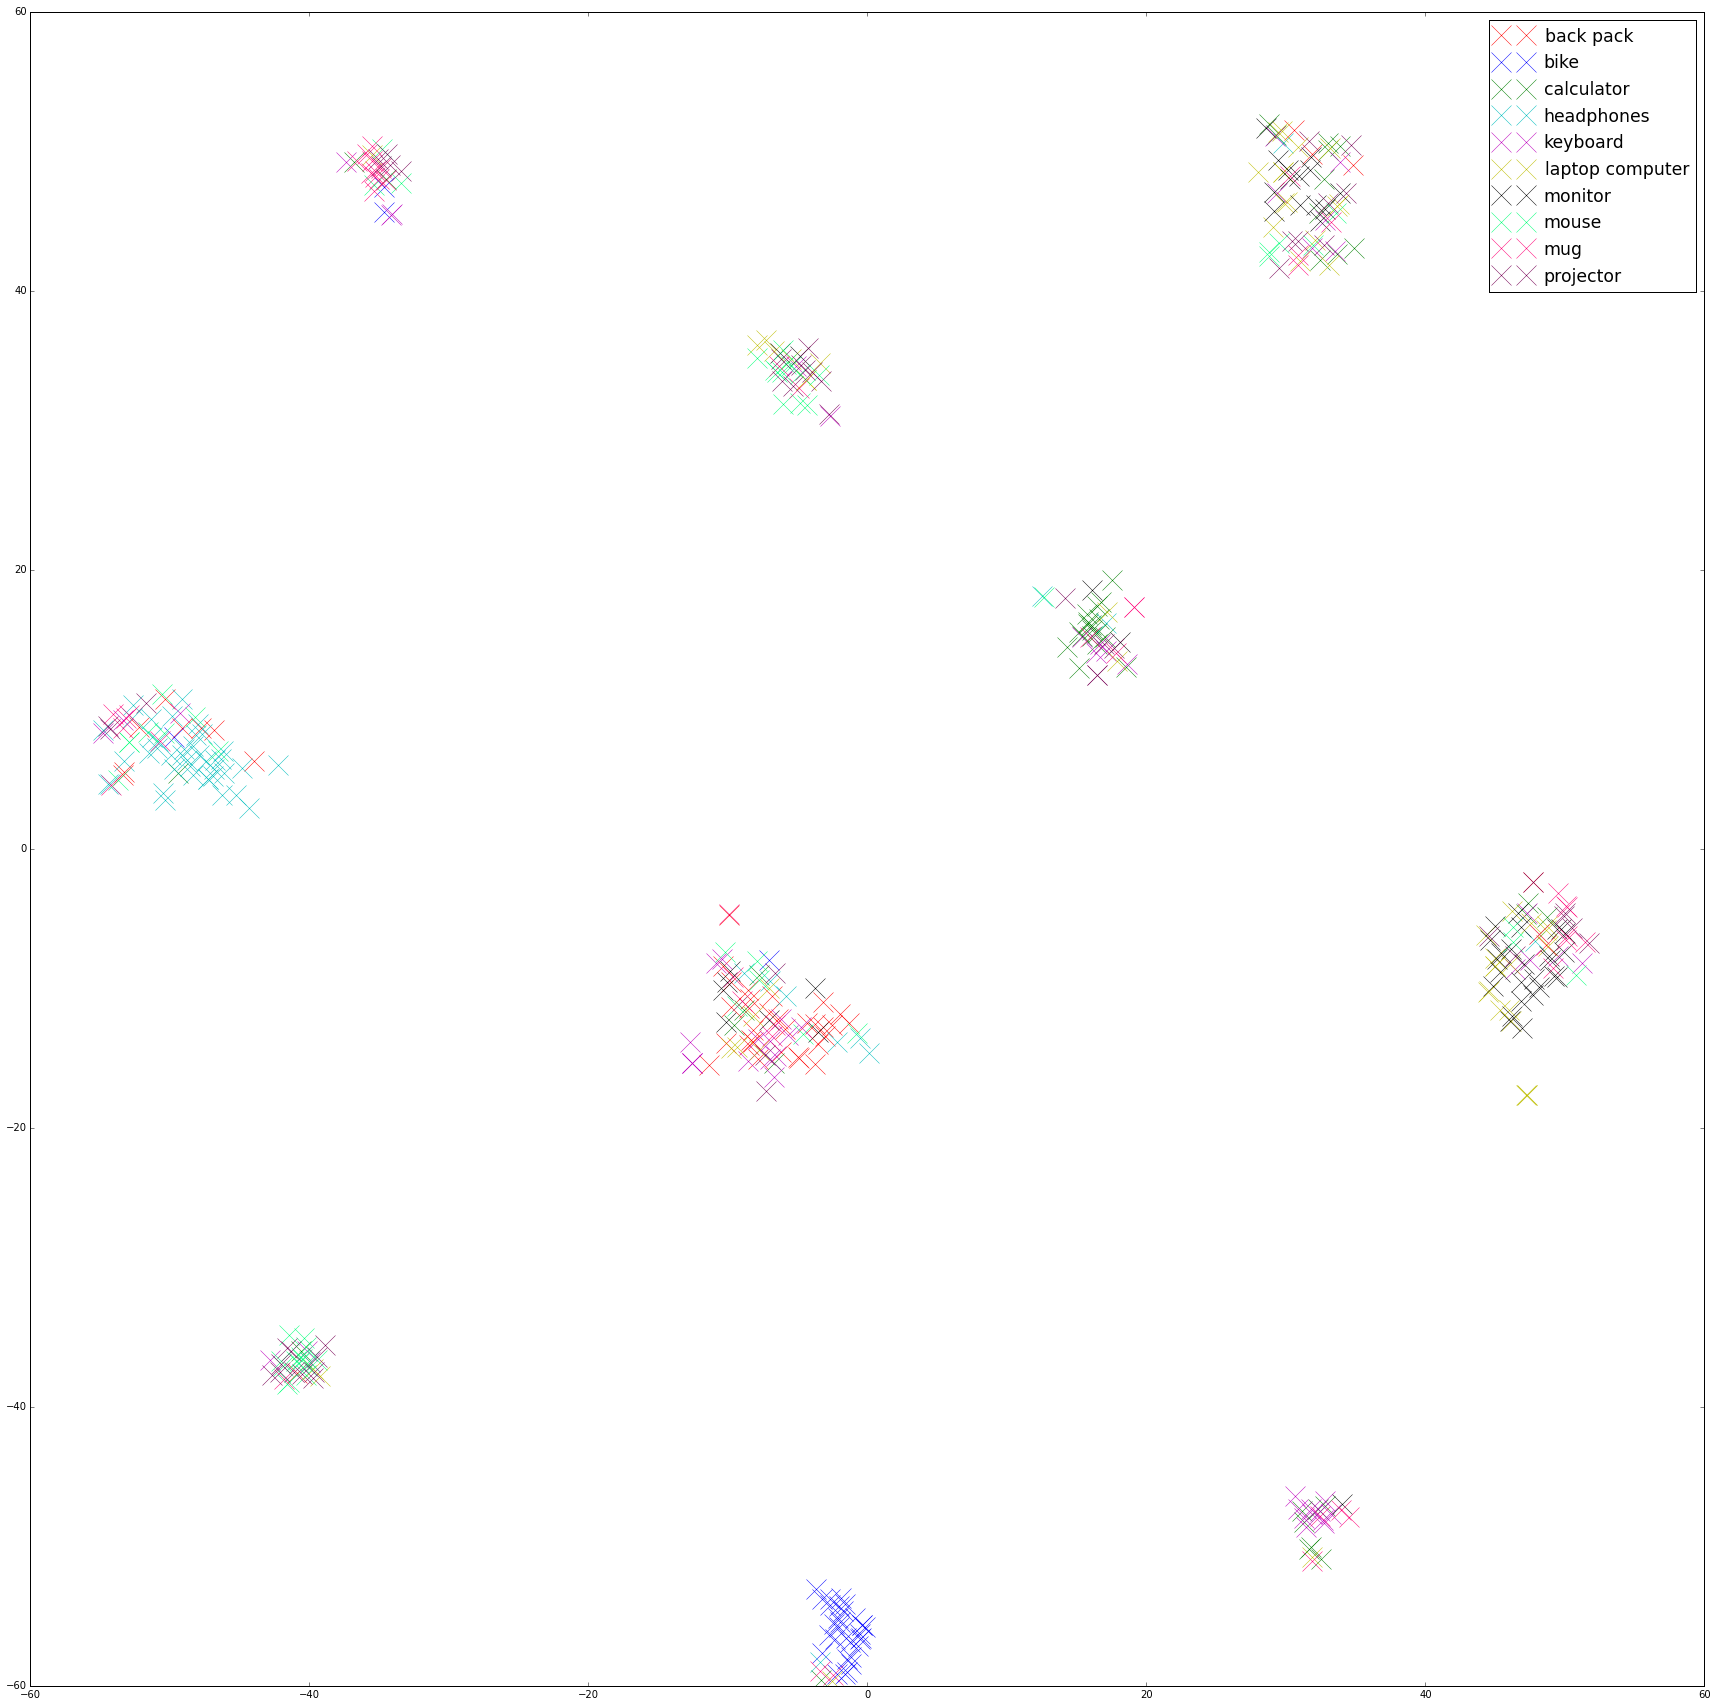

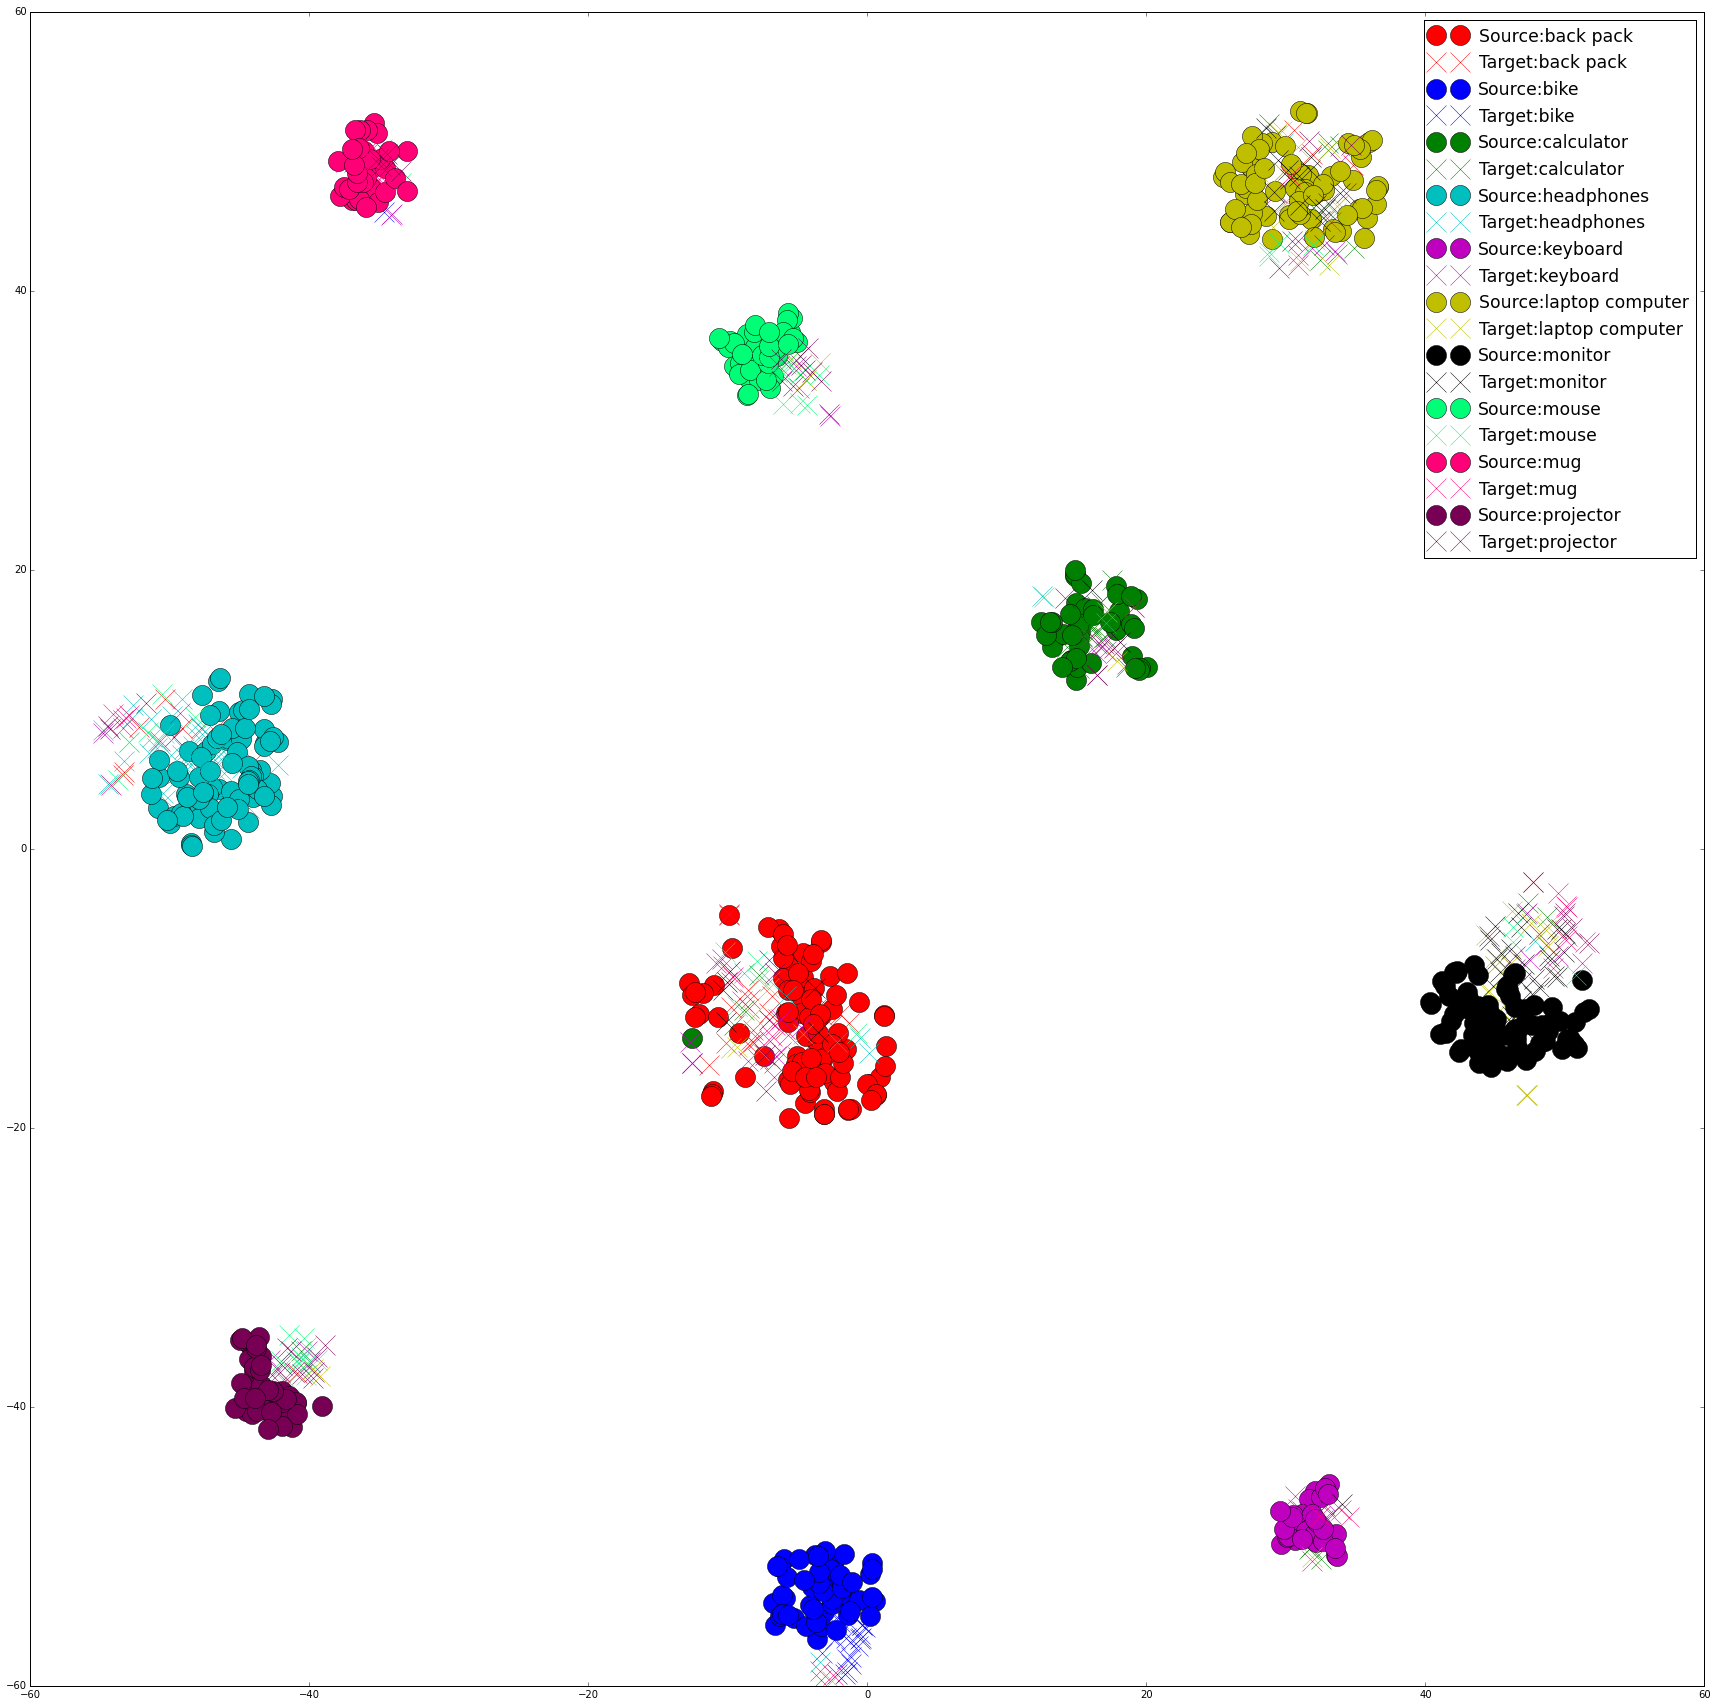

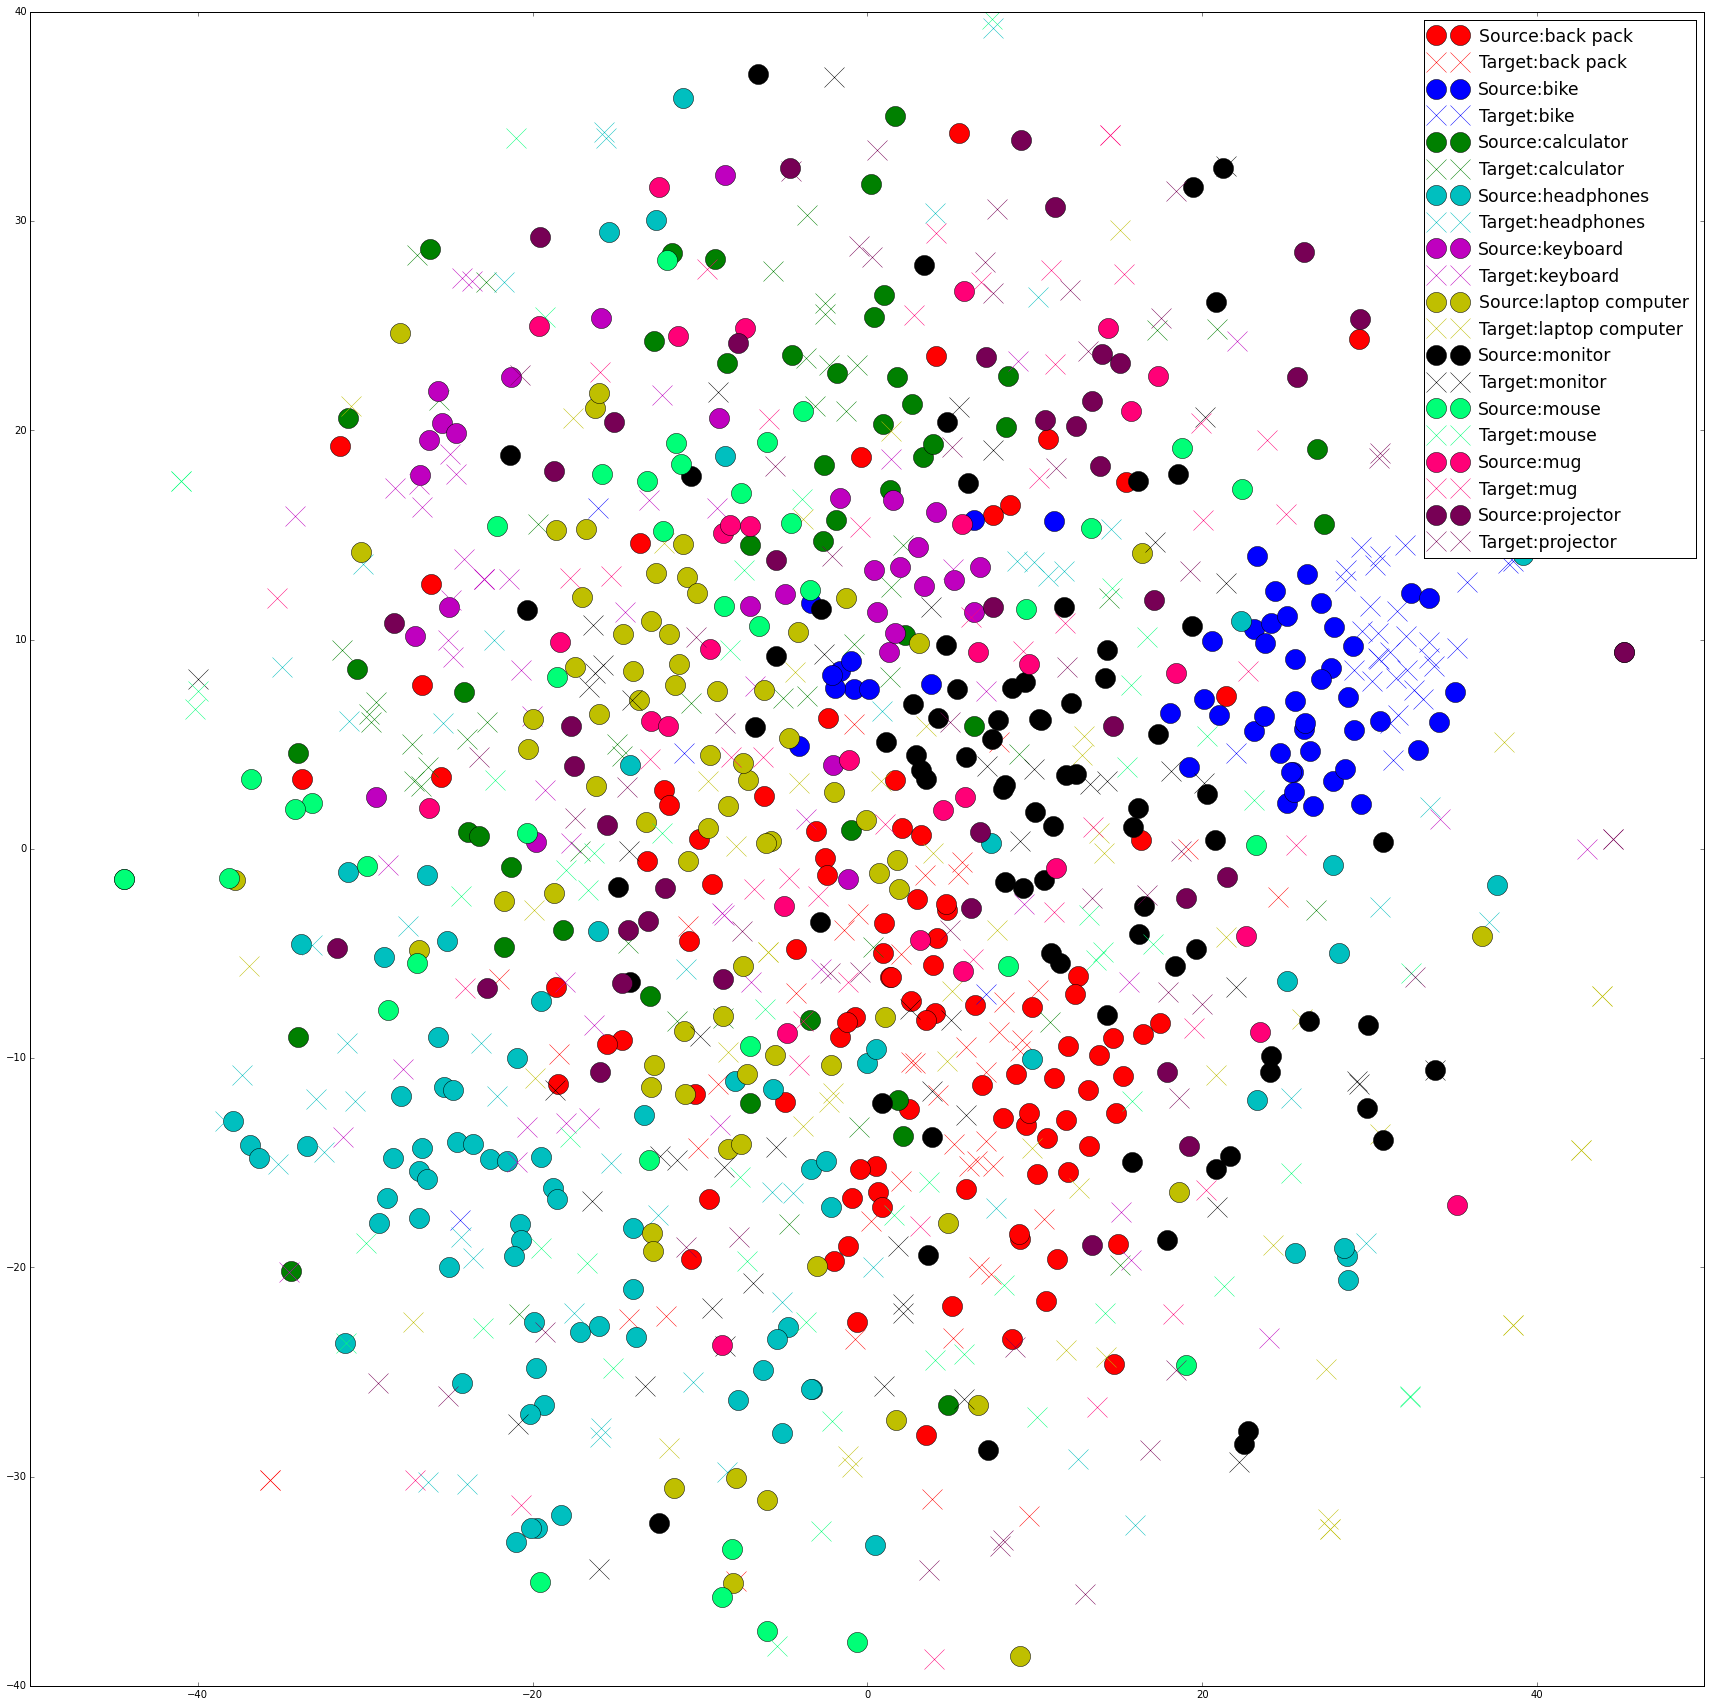

In [2]:
'''Model Construct'''
if __name__ == '__main__':
    
    source_file = '/home/cwhuang/DVTL/Dataset/Office/Caltech10_SURF_L10.npy'
    target_file = '/home/cwhuang/DVTL/Dataset/Office/amazon_SURF_L10.npy'
    
    source_data = np.load(source_file)
    target_data = np.load(target_file)
    
    #source_data, target_data = DataDuplicate.DataDuplicate(source_data, target_data)
    
    
    ########################################################################
    ###                        Coefficient Initial                       ###
    ########################################################################        

    x_dim = 800
    y_dim = 10    
    d_dim = 2    
    z_dim = 100                #dimension of latent feature
    a_dim = 50               #dimension of prior of latent feature    
    h_z_dim = 300             #dimension of hidden unit  
    h_a_dim = 70
    learning_rate = 0.005
    activation = T.nnet.sigmoid

    
    struct = VLDF_ANN.VLDF_ANN_struct()    
    encoder_template = nn.NN_struct()
    
    struct.encoder1.share.layer_dim = [x_dim+d_dim, 500, h_z_dim]
    struct.encoder1.share.activation = [activation, activation]
    struct.encoder1.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder1.share.decay = [1, 1]                
    struct.encoder1.mu.layer_dim = [h_z_dim, z_dim]
    struct.encoder1.mu.activation = [None]
    struct.encoder1.mu.learning_rate = [learning_rate]
    struct.encoder1.mu.decay = [1]      
    struct.encoder1.sigma.layer_dim = [h_z_dim, z_dim]
    struct.encoder1.sigma.activation = [None]
    struct.encoder1.sigma.learning_rate = [learning_rate]
    struct.encoder1.sigma.decay = [1]   

    struct.encoder2.share.layer_dim = [x_dim+d_dim, 500, h_z_dim]
    struct.encoder2.share.activation = [activation, activation]
    struct.encoder2.share.learning_rate = [learning_rate, learning_rate]
    struct.encoder2.share.decay = [1, 1]                
    struct.encoder2.mu.layer_dim = [h_z_dim, z_dim]
    struct.encoder2.mu.activation = [None]
    struct.encoder2.mu.learning_rate = [learning_rate]
    struct.encoder2.mu.decay = [1]      
    struct.encoder2.sigma.layer_dim = [h_z_dim, z_dim]
    struct.encoder2.sigma.activation = [None]
    struct.encoder2.sigma.learning_rate = [learning_rate]
    struct.encoder2.sigma.decay = [1]     
    
    struct.encoder3.share.layer_dim = [z_dim+y_dim, h_a_dim]
    struct.encoder3.share.activation = [activation]
    struct.encoder3.share.learning_rate = [learning_rate]
    struct.encoder3.share.decay = [1]                
    struct.encoder3.mu.layer_dim = [h_a_dim, a_dim]
    struct.encoder3.mu.activation = [None]
    struct.encoder3.mu.learning_rate = [learning_rate]
    struct.encoder3.mu.decay = [1]      
    struct.encoder3.sigma.layer_dim = [h_a_dim, a_dim]
    struct.encoder3.sigma.activation = [None]
    struct.encoder3.sigma.learning_rate = [learning_rate]
    struct.encoder3.sigma.decay = [1]

    struct.encoder4.share.layer_dim = [z_dim+d_dim, h_a_dim]
    struct.encoder4.share.activation = [activation]
    struct.encoder4.share.learning_rate = [learning_rate]
    struct.encoder4.share.decay = [1]                
    struct.encoder4.mu.layer_dim = [h_a_dim, a_dim]
    struct.encoder4.mu.activation = [None]
    struct.encoder4.mu.learning_rate = [learning_rate]
    struct.encoder4.mu.decay = [1]      
    struct.encoder4.sigma.layer_dim = [h_a_dim, a_dim]
    struct.encoder4.sigma.activation = [None]
    struct.encoder4.sigma.learning_rate = [learning_rate]
    struct.encoder4.sigma.decay = [1]    
    
    struct.encoder5.layer_dim = [z_dim, 50, y_dim]
    struct.encoder5.activation = [activation, T.nnet.softmax]   
    struct.encoder5.learning_rate = [learning_rate, learning_rate]
    struct.encoder5.decay = [1, 1]     

    #h_z_dim = 600
    struct.decoder1.share.layer_dim = [z_dim+z_dim, h_z_dim]
    struct.decoder1.share.activation = [activation]
    struct.decoder1.share.learning_rate = [learning_rate]
    struct.decoder1.share.decay = [1]                
    struct.decoder1.mu.layer_dim = [h_z_dim, x_dim]
    struct.decoder1.mu.activation = [None]
    struct.decoder1.mu.learning_rate = [learning_rate]
    struct.decoder1.mu.decay = [1]      
    struct.decoder1.sigma.layer_dim = [h_z_dim, x_dim]
    struct.decoder1.sigma.activation = [None]
    struct.decoder1.sigma.learning_rate = [learning_rate]
    struct.decoder1.sigma.decay = [1]      
    
    struct.decoder2.share.layer_dim = [a_dim+y_dim, h_a_dim]
    struct.decoder2.share.activation = [activation]
    struct.decoder2.share.learning_rate = [learning_rate]
    struct.decoder2.share.decay = [1]                
    struct.decoder2.mu.layer_dim = [h_a_dim, z_dim]
    struct.decoder2.mu.activation = [None]
    struct.decoder2.mu.learning_rate = [learning_rate]
    struct.decoder2.mu.decay = [1]      
    struct.decoder2.sigma.layer_dim = [h_a_dim, z_dim]
    struct.decoder2.sigma.activation = [None]
    struct.decoder2.sigma.learning_rate = [learning_rate]
    struct.decoder2.sigma.decay = [1]      

    struct.decoder3.share.layer_dim = [a_dim+d_dim, h_a_dim]
    struct.decoder3.share.activation = [activation]
    struct.decoder3.share.learning_rate = [learning_rate]
    struct.decoder3.share.decay = [1]                
    struct.decoder3.mu.layer_dim = [h_a_dim, z_dim]
    struct.decoder3.mu.activation = [None]
    struct.decoder3.mu.learning_rate = [learning_rate]
    struct.decoder3.mu.decay = [1]      
    struct.decoder3.sigma.layer_dim = [h_a_dim, z_dim]
    struct.decoder3.sigma.activation = [None]
    struct.decoder3.sigma.learning_rate = [learning_rate]
    struct.decoder3.sigma.decay = [1]     
    
    struct.DomainClassifier.layer_dim = [z_dim, 50, d_dim]
    struct.DomainClassifier.activation = [activation, T.nnet.softmax]   
    struct.DomainClassifier.learning_rate = [learning_rate, learning_rate]
    struct.DomainClassifier.decay = [1, 1]         
    
    coef = VLDF_ANN.VLDF_ANN_coef(
        alpha = 3000,
        beta = 1000,
        L = 10,
        optimize = 'Adam_update'        
    )        
    
    description = 'Office_VLDF_ANN_%s' % (coef.optimize)   
        
    features_model, test_model, trained_param = VLDF_ANN.VLDF_ANN_training(
        source_data=source_data,
        target_data=target_data,
        n_train_batches=5,
        n_epochs=100,
        k=10,
        struct = struct,
        coef = coef,
        description = description
    )
    
    fp.features_plot(features_model, test_model, source_data, target_data, description)
    
    train_fts_source, train_labels_source = source_data[0]
    train_fts_target, train_labels_target = target_data[0]
    
    zd_S = features_model()[6]
    zd_T = features_model()[7]
    
    zd_S, zd_T = util.feature_tsne(zd_S, zd_T)
    
    label_zd_S = []
    label_zd_T = []
    
    for i in range(y_dim):
        label_zd_S.append( zd_S[np.where(train_labels_source[:,i] == 1)[0], :] )
        label_zd_T.append( zd_T[np.where(train_labels_target[:,i] == 1)[0], :] )  
        
    #Both source, target zy feature
    title = 'Zd_feature_%s' % (description)
    fts = ()
    for i in range(y_dim):
        fts = fts+(label_zd_S[i][:,0], label_zd_S[i][:,1])
        fts = fts+(label_zd_T[i][:,0], label_zd_T[i][:,1])
    label = ['Source:back pack', 'Target:back pack', 'Source:bike', 'Target:bike', 'Source:calculator', 'Target:calculator',
             'Source:headphones','Target:headphones', 'Source:keyboard',  'Target:keyboard', 'Source:laptop computer',
             'Target:laptop computer', 'Source:monitor', 'Target:monitor', 'Source:mouse', 'Target:mouse', 'Source:mug',
             'Target:mug', 'Source:projector', 'Target:projector']
    color = [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10]
    marker = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
    line = False 
    legend = True
    util.data2plot(title=title, fts=fts, label=label, color=color, marker=marker, line=line, legend = legend)        